# **Lab 8.1 Transfer Learning & Multitask Learning**

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.models as models
import torchvision.transforms as transforms

from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset, Dataset, random_split
from PIL import Image

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
from sklearn.metrics import classification_report, confusion_matrix

Complete the `MultiLanguageHandwrittenDataset` class below. It should return:
- `image`: the image data
- `label`: the digit label (0-9)
- `language`: the language (Thai or English)


In [3]:
### START CODE HERE ###
class MultiLanguageHandwrittenDataset(Dataset):
    def __init__(self, root_dirs, languages, transforms=None):
        self.root_dirs = root_dirs
        self.languages = languages
        self.transform = transforms
        self.samples = []
        for root_dir, language in zip(self.root_dirs, self.languages):
            for subdir in os.scandir(root_dir):
                if subdir.is_dir():
                    label = int(subdir.name)
                    for file in os.scandir(subdir.path):
                        if file.is_file():
                            self.samples.append((file.path, label, language))
        print(self.samples)

    def __len__(self):
        return len(self.samples)
    
    def invert(self, image):
        return Image.fromarray(255 - np.array(image).astype(np.uint8))

    def __getitem__(self, idx):
        image_path, label, language = self.samples[idx]

        image = Image.open(image_path).convert('L')

        image_array = np.array(image)
        mean_pixel_value = np.mean(image_array)

        if mean_pixel_value < 128:
            image = self.invert(image)

        if self.transform:
            image = self.transform(image)

        label = torch.tensor(label)
        language = torch.tensor(language)
            
        return image, label, language
### END CODE HERE ###

use you `MultiLanguageHandwrittenDataset` here and display the first batch
<details>
<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical

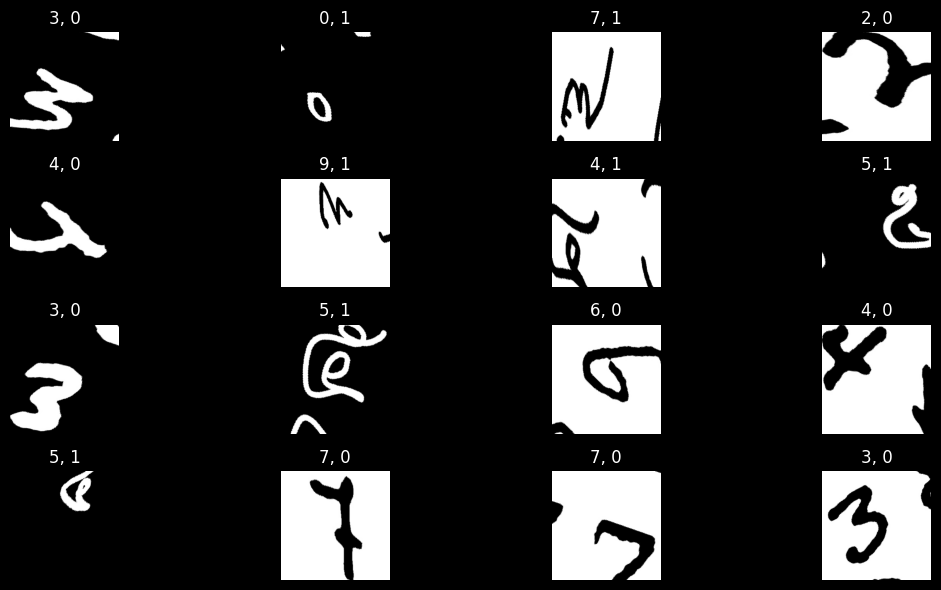

</details>

In [4]:
def imshow_grid(batch, labels, languages):
    
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))

    for i in range(16):
        image = batch[i].permute(1, 2, 0).numpy()
        label = labels[i]
        language = languages[i]

        ax = axes[i // 4, i % 4]
        ax.imshow(image, cmap='gray')
        ax.set_title(f"{label}, {language}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

[('C:\\Users\\Nickv\\Documents\\ImageProcessing\\Week8\\data\\eng-handwritten-dataset\\0\\img_1.jpg', 0, 0), ('C:\\Users\\Nickv\\Documents\\ImageProcessing\\Week8\\data\\eng-handwritten-dataset\\0\\img_1029.jpg', 0, 0), ('C:\\Users\\Nickv\\Documents\\ImageProcessing\\Week8\\data\\eng-handwritten-dataset\\0\\img_1046.jpg', 0, 0), ('C:\\Users\\Nickv\\Documents\\ImageProcessing\\Week8\\data\\eng-handwritten-dataset\\0\\img_1047.jpg', 0, 0), ('C:\\Users\\Nickv\\Documents\\ImageProcessing\\Week8\\data\\eng-handwritten-dataset\\0\\img_1076.jpg', 0, 0), ('C:\\Users\\Nickv\\Documents\\ImageProcessing\\Week8\\data\\eng-handwritten-dataset\\0\\img_108.jpg', 0, 0), ('C:\\Users\\Nickv\\Documents\\ImageProcessing\\Week8\\data\\eng-handwritten-dataset\\0\\img_1091.jpg', 0, 0), ('C:\\Users\\Nickv\\Documents\\ImageProcessing\\Week8\\data\\eng-handwritten-dataset\\0\\img_1093.jpg', 0, 0), ('C:\\Users\\Nickv\\Documents\\ImageProcessing\\Week8\\data\\eng-handwritten-dataset\\0\\img_1096.jpg', 0, 0), ('C:

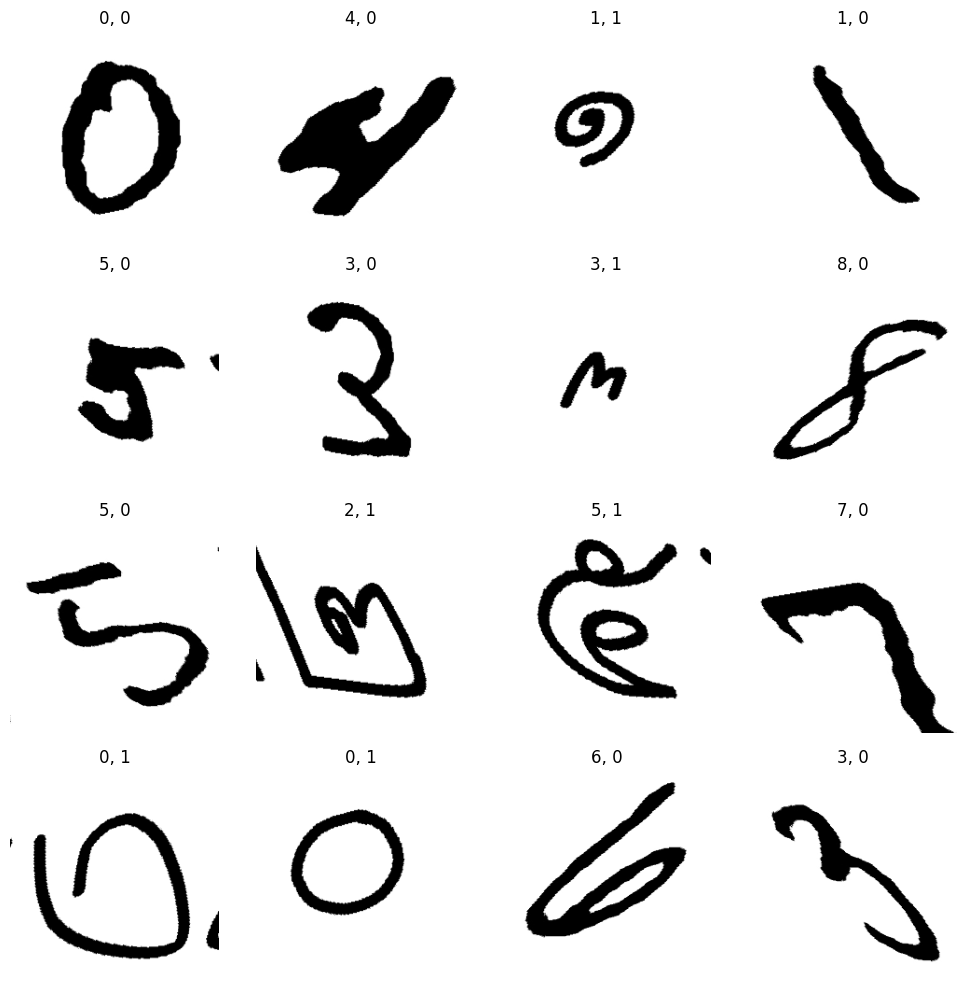

In [5]:
### START CODE HERE ###
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224), antialias=True),
    transforms.Pad(223, padding_mode='reflect'), 
    transforms.RandomAffine(degrees=15, shear=45),
    transforms.CenterCrop(224),
])

root_dirs = [r'C:\Users\Nickv\Documents\ImageProcessing\Week8\data\eng-handwritten-dataset', r'C:\Users\Nickv\Documents\ImageProcessing\Week8\data\thai-handwritten-dataset']
languages = [0, 1] #English = 0, Thai = 1

dataset = MultiLanguageHandwrittenDataset(root_dirs=root_dirs, languages=languages, transforms=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

batch, label, language = next(iter(dataloader))
imshow_grid(batch, label, language)

### END CODE HERE ###

## Transfer learning

Complete the `customVGG16` class below, which can create a pretrained VGG16 model and customize the number of fully connected (FC) layers. It also allows adding new convolutional layers and unfreezing pretrained layers based on their index.

In [6]:
### START CODE HERE ###
class customVGG16(nn.Module):
    def __init__(self, add_feat_dims=None, h_dims=None, num_classes=10, input_size=(1, 224, 224), trainable_layers_idx=None):
        super(customVGG16, self).__init__()
        self.vgg16 = models.vgg16(pretrained=True)

        self.vgg16.features[0] = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

        #Freeze Feature Extractor Layers
        for param in self.vgg16.features[:].parameters():
            param.requires_grad = False

        #Unfreeze Classifier Layers
        for param in self.vgg16.classifier.parameters():
            param.requires_grad = True

        if trainable_layers_idx is not None:
            for idx in trainable_layers_idx:
                for param in self.vgg16.features[idx].parameters():
                    param.requires_grad = True

        if add_feat_dims:
            features = []
            for i, out_ch in enumerate(add_feat_dims):
                if i == 0:
                    features.append(nn.Conv2d(512, out_ch, kernel_size=3, padding=1))
                else:
                    features.append(nn.Conv2d(add_feat_dims[i-1], out_ch, kernel_size=3, padding=1))
                features.append(nn.ReLU())
            self.vgg16.features = nn.Sequential(self.vgg16.features, *features)

        input_size_fc1 = self._get_input_size_fc(input_size)

        if h_dims:
            layers = []
            for i, hdim in enumerate(h_dims):
                if i == 0:
                    layers.append(nn.Linear(input_size_fc1, hdim))
                else:
                    layers.append(nn.Linear(h_dims[i-1], hdim))
                layers.append(nn.Dropout(0.4))
                layers.append(nn.ReLU())
            self.vgg16.classifier = nn.Sequential(*layers, nn.Linear(h_dims[-1], num_classes))
        else:
            self.vgg16.classifier = nn.Linear(input_size_fc1, num_classes)

    def _get_input_size_fc(self, input_shape):
        with torch.no_grad():
            x = torch.zeros(1, *input_shape)
            x = self.vgg16.features(x)
            x = self.vgg16.avgpool(x)
            x = torch.flatten(x, 1)
            
            return x.size(1)
    
    def forward(self, x):
        x = self.vgg16.features(x)
        x = self.vgg16.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.vgg16.classifier(x)
        return x
    
### END CODE HERE ###


Example usage
```
trainable_layers_idx = [-1,-2,-3,-4,-5]
model = customVGG16(add_feat_dims=[512],h_dims=[512,256,256],input_size=(3,224,224),trainable_layers_idx=trainable_layers_idx)

```


Complete the `train` function below, which logs Loss/train, Accuracy/train, Loss/test, and Accuracy/test to [TensorBoard](https://pytorch.org/docs/stable/tensorboard.html).Then, complete the evaluate_task function, which prints the classification report and plots the confusion matrix

In [7]:
### START CODE HERE ###

def train(model, opt, loss_fn, train_loader, val_loader, epochs=10, writer=None, checkpoint_path=None, device='cuda', task='digit'):
    print("🤖 Training on", device)
    model = model.to(device)
    
    for epoch in range(epochs):
        model.train()
        avg_train_loss = 0.0
        step = 0
        train_bar = tqdm(train_loader, desc=f'🚀 Training Epoch [{epoch+1}/{epochs}]', unit='batch')
        
        for images, digits, languages in train_bar:
            images = images.to(device)

            if task == 'digit':
                digits = digits.to(device)
                outputs = model(images)
                loss = loss_fn(outputs, digits)
            elif task == 'language':
                languages = languages.to(device)
                outputs = model(images)
                loss = loss_fn(outputs, languages)

            opt.zero_grad()
            loss.backward()
            opt.step()

            avg_train_loss += loss.item()
            step += 1

            train_bar.set_postfix(loss=loss.item())

        avg_train_loss /= step
        
        model.eval()
        avg_val_loss = 0.0
        val_bar = tqdm(val_loader, desc='📄 Validation', unit='batch')
            
        with torch.no_grad():
            for images, digits, languages in val_bar:
                images = images.to(device)

                if task == 'digit':
                    digits = digits.to(device)
                    outputs = model(images)
                    val_loss = loss_fn(outputs, digits)
                elif task == 'language':
                    languages = languages.to(device)
                    outputs = model(images)
                    val_loss = loss_fn(outputs, languages)

                avg_val_loss += val_loss.item()

        avg_val_loss /= len(val_loader)
    
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

        if writer:
            writer.add_scalar('Loss/Train', avg_train_loss, epoch + 1)
            writer.add_scalar('Loss/Validation', avg_val_loss, epoch + 1)

        if checkpoint_path:
            torch.save(model.state_dict(), f"{checkpoint_path}_epoch_{epoch+1}.pth")

    print("🏁 Training completed.")


def evaluate_task(y_true, y_pred, target_names="Task"):
    clf_report = classification_report(y_true, y_pred, target_names=target_names, zero_division=1)
    conf_matrix = confusion_matrix(y_true, y_pred)
    print("\nClassification Report:\n", clf_report)

    plt.figure(figsize=(8, 6))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()

    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)

    thresh = conf_matrix.max() / 2.
    for i, j in np.ndindex(conf_matrix.shape):
        plt.text(j, i, format(conf_matrix[i, j], 'd'), ha="center", va="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    
    plt.tight_layout()
    plt.show()

### END CODE HERE ###


### Transfer learning for Digit classification task
Declare the `customVGG16` model with custom layers of your choice. Then, split the dataset into training, validation, and test sets, and proceed to train the model.

In [9]:
dataset_size = len(dataset)
train_size = int(0.7 * dataset_size)
val_size = int(0.15 * dataset_size)
test_size = dataset_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, pin_memory=True)

In [12]:
### START CODE HERE ###
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

model1 = customVGG16()

writer = SummaryWriter(log_dir='./runs/digit_experiment')
opt = optim.Adam(model1.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
train(model=model1, opt=opt, loss_fn=loss_fn, epochs=20, train_loader=train_loader, val_loader=val_loader, writer=writer, device='cuda', checkpoint_path="models/model1/model1")
writer.close()

### END CODE HERE ###

🤖 Training on cuda


📄 Validation: 100%|██████████| 33/33 [00:37<00:00,  1.13s/batch]


Epoch [1/20], Train Loss: 1.5719, Val Loss: 1.1035


📄 Validation: 100%|██████████| 33/33 [00:23<00:00,  1.43batch/s]


Epoch [2/20], Train Loss: 0.9745, Val Loss: 0.9166


📄 Validation: 100%|██████████| 33/33 [00:22<00:00,  1.44batch/s]


Epoch [3/20], Train Loss: 0.7973, Val Loss: 0.7712


📄 Validation: 100%|██████████| 33/33 [00:22<00:00,  1.44batch/s]


Epoch [4/20], Train Loss: 0.6976, Val Loss: 0.6432


📄 Validation: 100%|██████████| 33/33 [00:22<00:00,  1.45batch/s]


Epoch [5/20], Train Loss: 0.6201, Val Loss: 0.6621


📄 Validation: 100%|██████████| 33/33 [00:22<00:00,  1.45batch/s]


Epoch [6/20], Train Loss: 0.5793, Val Loss: 0.5773


📄 Validation: 100%|██████████| 33/33 [00:22<00:00,  1.47batch/s]


Epoch [7/20], Train Loss: 0.5268, Val Loss: 0.5623


📄 Validation: 100%|██████████| 33/33 [00:22<00:00,  1.46batch/s]


Epoch [8/20], Train Loss: 0.4993, Val Loss: 0.5965


📄 Validation: 100%|██████████| 33/33 [00:22<00:00,  1.47batch/s]


Epoch [9/20], Train Loss: 0.4592, Val Loss: 0.5314


📄 Validation: 100%|██████████| 33/33 [00:22<00:00,  1.46batch/s]


Epoch [10/20], Train Loss: 0.4513, Val Loss: 0.5787


📄 Validation: 100%|██████████| 33/33 [00:22<00:00,  1.47batch/s]


Epoch [11/20], Train Loss: 0.4052, Val Loss: 0.5339


📄 Validation: 100%|██████████| 33/33 [00:22<00:00,  1.49batch/s]


Epoch [12/20], Train Loss: 0.3864, Val Loss: 0.5476


📄 Validation: 100%|██████████| 33/33 [00:22<00:00,  1.48batch/s]


Epoch [13/20], Train Loss: 0.3789, Val Loss: 0.5179


📄 Validation: 100%|██████████| 33/33 [00:22<00:00,  1.47batch/s]


Epoch [14/20], Train Loss: 0.3390, Val Loss: 0.4688


📄 Validation: 100%|██████████| 33/33 [00:22<00:00,  1.48batch/s]


Epoch [15/20], Train Loss: 0.3176, Val Loss: 0.4488


📄 Validation: 100%|██████████| 33/33 [00:22<00:00,  1.45batch/s]


Epoch [16/20], Train Loss: 0.3382, Val Loss: 0.4836


📄 Validation: 100%|██████████| 33/33 [00:22<00:00,  1.47batch/s]


Epoch [17/20], Train Loss: 0.3204, Val Loss: 0.4902


📄 Validation: 100%|██████████| 33/33 [00:22<00:00,  1.47batch/s]


Epoch [18/20], Train Loss: 0.2931, Val Loss: 0.5032


📄 Validation: 100%|██████████| 33/33 [00:22<00:00,  1.48batch/s]


Epoch [19/20], Train Loss: 0.2905, Val Loss: 0.4375


📄 Validation: 100%|██████████| 33/33 [00:22<00:00,  1.48batch/s]

Epoch [20/20], Train Loss: 0.2785, Val Loss: 0.4920
🏁 Training completed.


use `evaluate_task` to evlauate you model1 here.
<details>
<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical

```
Digit - Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.92      0.84        26
           1       0.75      0.94      0.83        32
           2       0.66      0.54      0.59        39
           3       0.76      0.54      0.63        35
           4       0.68      0.53      0.60        47
           5       0.52      0.42      0.47        33
           6       0.59      0.88      0.71        33
           7       0.46      0.59      0.52        27
           8       0.70      0.65      0.67        43
           9       0.85      0.83      0.84        35

    accuracy                           0.67       350
   macro avg       0.67      0.68      0.67       350
weighted avg       0.68      0.67      0.67       350

```

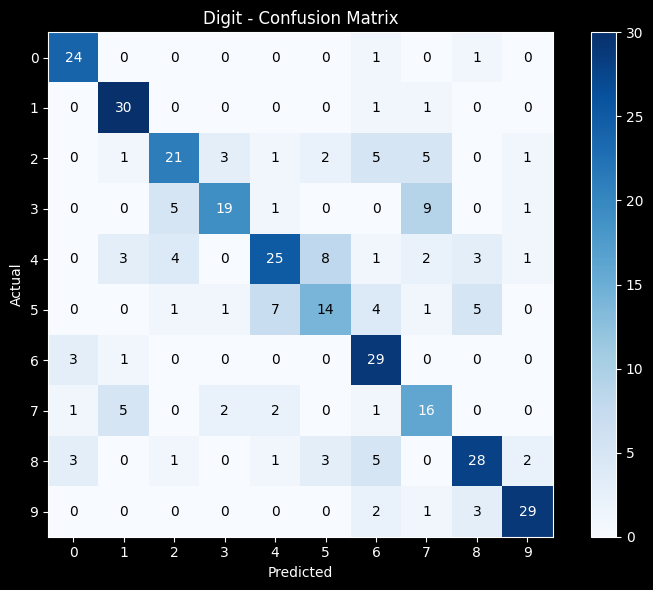

</details>

In [13]:
model1 = customVGG16()
model1.load_state_dict(torch.load(r'C:\Users\Nickv\Documents\ImageProcessing\Week8\models\model1\model1_epoch_20.pth'))
model1.eval()

customVGG16(
  (vgg16): VGG(
    (features): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (1


Classification Report:
               precision    recall  f1-score   support

     Class 0       0.92      0.94      0.93        52
     Class 1       0.85      0.96      0.90        54
     Class 2       0.84      0.96      0.90        49
     Class 3       0.95      0.70      0.81        54
     Class 4       0.86      0.91      0.88        54
     Class 5       0.75      0.93      0.83        43
     Class 6       0.94      0.96      0.95        52
     Class 7       0.81      0.94      0.87        53
     Class 8       0.93      0.71      0.80        52
     Class 9       0.92      0.74      0.82        62

    accuracy                           0.87       525
   macro avg       0.88      0.88      0.87       525
weighted avg       0.88      0.87      0.87       525



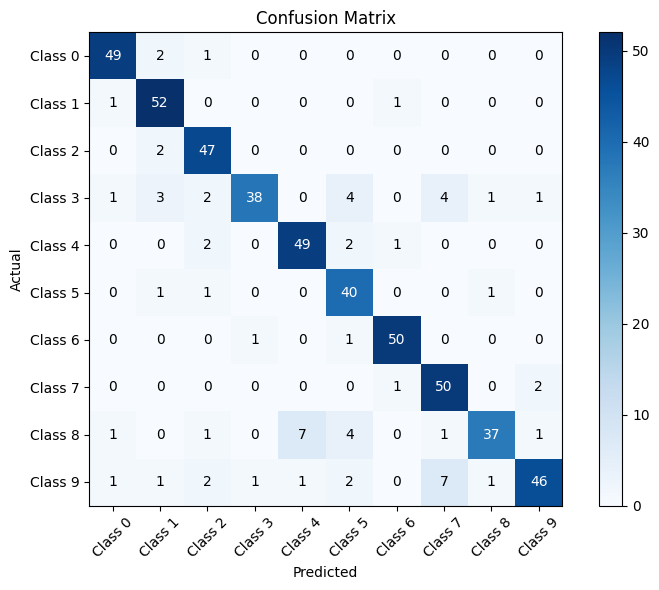

In [17]:
### START CODE HERE ###

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model1 = model1.to(device)
all_labels = []
all_predictions = []

for images, labels, _ in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    with torch.no_grad():
        outputs = model1(images)
        _, predicted = torch.max(outputs, 1)

    all_labels.extend(labels.cpu().numpy())
    all_predictions.extend(predicted.cpu().numpy())

all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

evaluate_task(all_labels, all_predictions, target_names=[f'Class {i}' for i in range(10)])

### END CODE HERE ###

### Transfer learning for Language classification task
Declare a NEW `customVGG16` model with custom layers of your choice.

In [8]:
dataset_size = len(dataset)
train_size = int(0.7 * dataset_size)
val_size = int(0.15 * dataset_size)
test_size = dataset_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [10]:
### START CODE HERE ###
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

model2 = customVGG16(num_classes=2)

writer = SummaryWriter(log_dir='./runs/language_experiment')
opt = optim.Adam(model2.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
train(model=model2, opt=opt, loss_fn=loss_fn, epochs=10, train_loader=train_loader, val_loader=val_loader, writer=writer, device= 'cuda' if torch.cuda.is_available() else 'cpu', checkpoint_path="models/model2/model2", task='language')
writer.close()

### END CODE HERE ###

c:\Users\Nickv\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Nickv\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


🤖 Training on cuda


📄 Validation: 100%|██████████| 33/33 [00:26<00:00,  1.26batch/s]


Epoch [1/10], Train Loss: 0.1962, Val Loss: 0.1071


📄 Validation: 100%|██████████| 33/33 [00:23<00:00,  1.41batch/s]


Epoch [2/10], Train Loss: 0.0826, Val Loss: 0.0824


📄 Validation: 100%|██████████| 33/33 [00:25<00:00,  1.29batch/s]


Epoch [3/10], Train Loss: 0.0520, Val Loss: 0.0512


📄 Validation: 100%|██████████| 33/33 [00:23<00:00,  1.38batch/s]


Epoch [4/10], Train Loss: 0.0434, Val Loss: 0.0419


📄 Validation: 100%|██████████| 33/33 [00:23<00:00,  1.39batch/s]


Epoch [5/10], Train Loss: 0.0334, Val Loss: 0.0581


📄 Validation: 100%|██████████| 33/33 [00:23<00:00,  1.42batch/s]


Epoch [6/10], Train Loss: 0.0357, Val Loss: 0.0342


📄 Validation: 100%|██████████| 33/33 [00:23<00:00,  1.41batch/s]


Epoch [7/10], Train Loss: 0.0304, Val Loss: 0.0240


📄 Validation: 100%|██████████| 33/33 [00:23<00:00,  1.42batch/s]


Epoch [8/10], Train Loss: 0.0222, Val Loss: 0.0403


📄 Validation: 100%|██████████| 33/33 [00:23<00:00,  1.41batch/s]


Epoch [9/10], Train Loss: 0.0210, Val Loss: 0.0405


📄 Validation: 100%|██████████| 33/33 [00:23<00:00,  1.41batch/s]

Epoch [10/10], Train Loss: 0.0287, Val Loss: 0.0511
🏁 Training completed.


use `evaluate_task` to evlauate you model2 here.
<details>
<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical

```
Language - Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       175
           1       0.99      0.93      0.96       175

    accuracy                           0.96       350
   macro avg       0.96      0.96      0.96       350
weighted avg       0.96      0.96      0.96       350

```

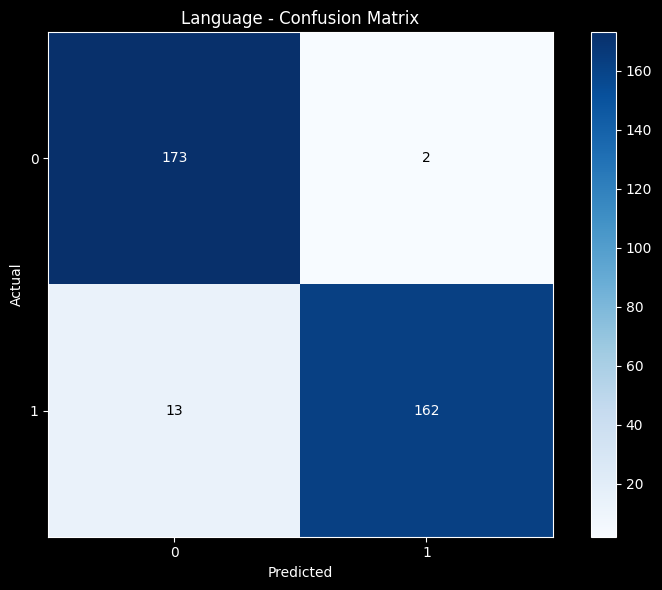

</details>

In [11]:
model2 = customVGG16(num_classes=2)
model2.load_state_dict(torch.load(r'C:\Users\Nickv\Documents\ImageProcessing\Week8\models\model2\model2_epoch_10.pth'))
model2.eval()

customVGG16(
  (vgg16): VGG(
    (features): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (1


Classification Report:
               precision    recall  f1-score   support

     Class 0       0.98      0.99      0.99       253
     Class 1       0.99      0.99      0.99       272

    accuracy                           0.99       525
   macro avg       0.99      0.99      0.99       525
weighted avg       0.99      0.99      0.99       525



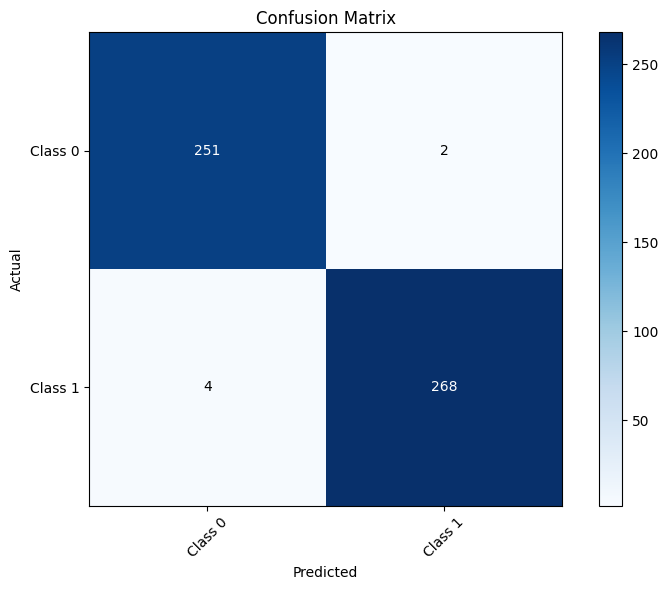

In [12]:
### START CODE HERE ###

device = 'cuda' if torch.cuda.is_available() else 'cpu'
all_labels = []
all_predictions = []
model2 = model2.to(device)

for images, _, languages in test_loader:
    images = images.to(device)
    languages = languages.to(device)

    with torch.no_grad():
        outputs = model2(images)
        _, predicted = torch.max(outputs, 1)

    all_labels.extend(languages.cpu().numpy())
    all_predictions.extend(predicted.cpu().numpy())

all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

evaluate_task(all_labels, all_predictions, target_names=['Class 0', 'Class 1'])

### END CODE HERE ###

---

## Multitask learning

Complete the `customVGG16_multitask` class below, which can create a pretrained VGG16 model and customize the number of fully connected (FC) layers. It also allows adding new convolutional layers and unfreezing pretrained layers based on their index. Additionally, it allows branching the model into two heads for multitask learning, where one head handles digit classification, and the other handles language classification

In [13]:
class customVGG16_multitask(nn.Module):
    def __init__(self, add_feat_dims=None, h_dims=None, input_size=(1, 224, 224), trainable_layers_idx=None):
        super(customVGG16_multitask, self).__init__()
        self.vgg16 = models.vgg16(pretrained=True)

        self.vgg16.features[0] = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

        #Freeze Feature Extractor Layers
        for param in self.vgg16.features[:].parameters():
            param.requires_grad = False

        #Unfreeze Classifier Layers
        for param in self.vgg16.classifier.parameters():
            param.requires_grad = True

        if trainable_layers_idx is not None:
            for idx in trainable_layers_idx:
                for param in self.vgg16.features[idx].parameters():
                    param.requires_grad = True

        if add_feat_dims:
            features = []
            for i, out_ch in enumerate(add_feat_dims):
                if i == 0:
                    features.append(nn.Conv2d(512, out_ch, kernel_size=3, padding=1))
                else:
                    features.append(nn.Conv2d(add_feat_dims[i-1], out_ch, kernel_size=3, padding=1))
                features.append(nn.ReLU())
            self.vgg16.features = nn.Sequential(self.vgg16.features, *features)

        input_size_fc1 = self._get_input_size_fc(input_size)

        if h_dims:
            self.digit = self._create_fc_layers(input_size_fc1, h_dims, 10)
            self.lang = self._create_fc_layers(input_size_fc1, h_dims, 2)
        else:
            self.digit = nn.Linear(input_size_fc1, 10)
            self.lang = nn.Linear(input_size_fc1, 2)

    def _create_fc_layers(self, input_dim, h_dims, output_dim):
        layers = []
        for i, hdim in enumerate(h_dims):
            if i == 0:
                layers.append(nn.Linear(input_dim, hdim))
            else:
                layers.append(nn.Linear(h_dims[i-1], hdim))
            layers.append(nn.Dropout(0.4))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(h_dims[-1], output_dim))
        return nn.Sequential(*layers)

    def _get_input_size_fc(self, input_shape):
        with torch.no_grad():
            x = torch.zeros(1, *input_shape)
            x = self.vgg16.features(x)
            x = self.vgg16.avgpool(x)
            x = torch.flatten(x[0])
            return x.size(0)
    
    def forward(self, x):
        x = self.vgg16.features(x)
        x = self.vgg16.avgpool(x)
        x = torch.flatten(x, 1)

        out_digit = self.digit(x)
        out_lang = self.lang(x)

        return out_digit, out_lang
        

Complete the `train_multi` function below, which train multitask model and  logs Loss/train, Accuracy/train, Loss/test, and Accuracy/test to [TensorBoard](https://pytorch.org/docs/stable/tensorboard.html).

In [14]:
def train_multi(model, opt, loss_fn, train_loader, val_loader, epochs=10, writer=None, checkpoint_path=None, device='cpu'):
    print("🤖 Training on", device)
    model = model.to(device)
    
    for epoch in range(epochs):
        model.train()
        avg_train_loss = 0.0
        step = 0
        train_bar = tqdm(train_loader, desc=f'🚀 Training Epoch [{epoch+1}/{epochs}]', unit='batch')
        
        for images, digits, languages in train_bar:
            images = images.to(device)
            digits = digits.to(device)
            languages = languages.to(device)

            out_digits, out_languages = model(images)

            loss_digits = loss_fn(out_digits, digits)
            loss_languages = loss_fn(out_languages, languages)
            loss = loss_digits + loss_languages

            opt.zero_grad()
            loss.backward()
            opt.step()

            avg_train_loss += loss.item()
            step += 1

            train_bar.set_postfix(loss=loss.item())

        avg_train_loss /= step
        
        model.eval()
        avg_val_loss = 0.0
        val_bar = tqdm(val_loader, desc='📄 Validation', unit='batch')
            
        with torch.no_grad():
            for images, digits, languages in val_bar:
                images = images.to(device)
                digits = digits.to(device)
                languages = languages.to(device)

                out_digits, out_languages = model(images)

                loss_digits = loss_fn(out_digits, digits)
                loss_languages = loss_fn(out_languages, languages)
                val_loss = loss_digits + loss_languages

                avg_val_loss += val_loss.item()

        avg_val_loss /= len(val_loader)
    
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

        if writer:
            writer.add_scalar('Loss/Train', avg_train_loss, epoch + 1)
            writer.add_scalar('Loss/Validation', avg_val_loss, epoch + 1)

        if checkpoint_path:
            torch.save(model.state_dict(), f"{checkpoint_path}_epoch_{epoch+1}.pth")

    print("🏁 Training completed.")

In [16]:
### START CODE HERE ###
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

model = customVGG16_multitask()

dataset_size = len(dataset)
train_size = int(0.7 * dataset_size)
val_size = int(0.15 * dataset_size)
test_size = dataset_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

writer = SummaryWriter(log_dir='./runs/custom_vgg16_experiment')
opt = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
train_multi(model=model, opt=opt, loss_fn=loss_fn, train_loader=train_loader, val_loader=val_loader, epochs=10, writer=writer, checkpoint_path='models/model_multitask/model', device= 'cuda' if torch.cuda.is_available() else 'cpu')
writer.close()

### END CODE HERE ###

🤖 Training on cuda


📄 Validation: 100%|██████████| 33/33 [00:21<00:00,  1.53batch/s]


Epoch [1/10], Train Loss: 1.0890, Val Loss: 0.5832


📄 Validation: 100%|██████████| 33/33 [00:21<00:00,  1.53batch/s]


Epoch [2/10], Train Loss: 0.4728, Val Loss: 0.4959


📄 Validation: 100%|██████████| 33/33 [00:21<00:00,  1.52batch/s]


Epoch [3/10], Train Loss: 0.3837, Val Loss: 0.3973


📄 Validation: 100%|██████████| 33/33 [00:21<00:00,  1.51batch/s]


Epoch [4/10], Train Loss: 0.3366, Val Loss: 0.3262


📄 Validation: 100%|██████████| 33/33 [00:21<00:00,  1.52batch/s]


Epoch [5/10], Train Loss: 0.2470, Val Loss: 0.4193


📄 Validation: 100%|██████████| 33/33 [00:21<00:00,  1.52batch/s]


Epoch [6/10], Train Loss: 0.2251, Val Loss: 0.3281


📄 Validation: 100%|██████████| 33/33 [00:21<00:00,  1.51batch/s]


Epoch [7/10], Train Loss: 0.1808, Val Loss: 0.3459


📄 Validation: 100%|██████████| 33/33 [00:21<00:00,  1.52batch/s]


Epoch [8/10], Train Loss: 0.1839, Val Loss: 0.3330


📄 Validation: 100%|██████████| 33/33 [00:21<00:00,  1.53batch/s]


Epoch [9/10], Train Loss: 0.1543, Val Loss: 0.3135


📄 Validation: 100%|██████████| 33/33 [00:21<00:00,  1.52batch/s]


Epoch [10/10], Train Loss: 0.1516, Val Loss: 0.2911
🏁 Training completed.


use `evaluate_task` to evlauate you model here.
<details>
<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical

```
Digit - Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.89      0.86        35
           1       0.81      0.91      0.85        32
           2       0.76      0.55      0.64        40
           3       0.53      0.66      0.58        32
           4       0.54      0.29      0.38        24
           5       0.51      0.57      0.54        37
           6       0.68      0.72      0.70        29
           7       0.60      0.71      0.65        34
           8       0.62      0.71      0.66        48
           9       0.68      0.49      0.57        39

    accuracy                           0.65       350
   macro avg       0.66      0.65      0.64       350
weighted avg       0.66      0.65      0.65       350

```

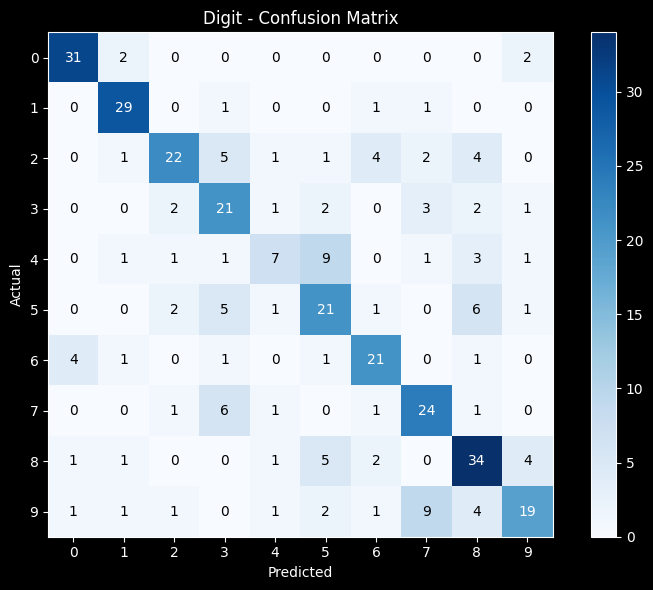

```
Language - Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       172
           1       0.98      0.98      0.98       178

    accuracy                           0.98       350
   macro avg       0.98      0.98      0.98       350
weighted avg       0.98      0.98      0.98       350
```

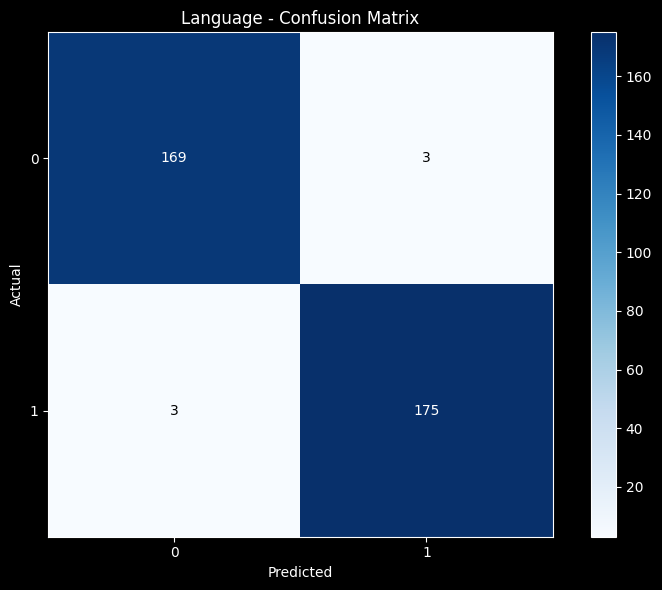

</details>

In [18]:
model = customVGG16_multitask()
model.load_state_dict(torch.load(r'C:\Users\Nickv\Documents\ImageProcessing\Week8\models\model_multitask\model_epoch_10.pth'))
model.eval()

customVGG16_multitask(
  (vgg16): VGG(
    (features): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True


Classification Report:
               precision    recall  f1-score   support

     Class 0       0.84      0.96      0.90        51
     Class 1       0.93      0.92      0.93        61
     Class 2       1.00      0.91      0.95        46
     Class 3       0.80      0.96      0.87        47
     Class 4       0.85      0.87      0.86        61
     Class 5       0.92      0.90      0.91        40
     Class 6       0.96      0.90      0.93        58
     Class 7       0.96      0.84      0.89        55
     Class 8       0.96      0.86      0.91        51
     Class 9       0.87      0.95      0.90        55

    accuracy                           0.90       525
   macro avg       0.91      0.91      0.91       525
weighted avg       0.91      0.90      0.91       525



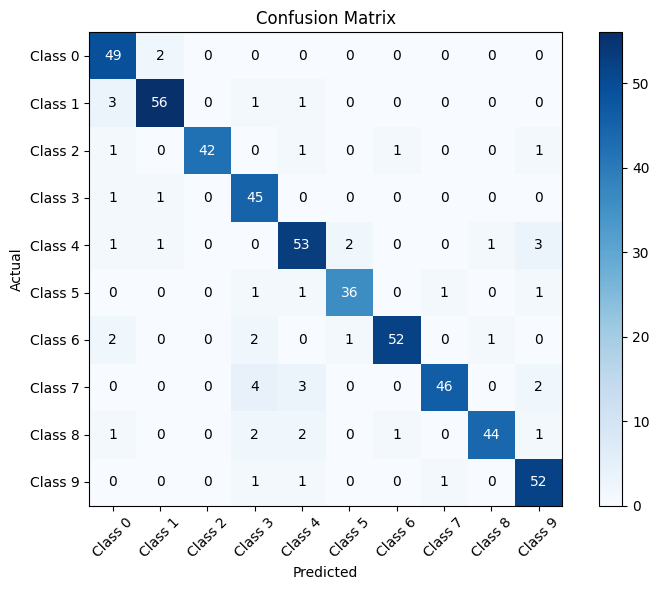


Classification Report:
               precision    recall  f1-score   support

     Class 0       0.99      1.00      0.99       242
     Class 1       1.00      0.99      0.99       283

    accuracy                           0.99       525
   macro avg       0.99      0.99      0.99       525
weighted avg       0.99      0.99      0.99       525



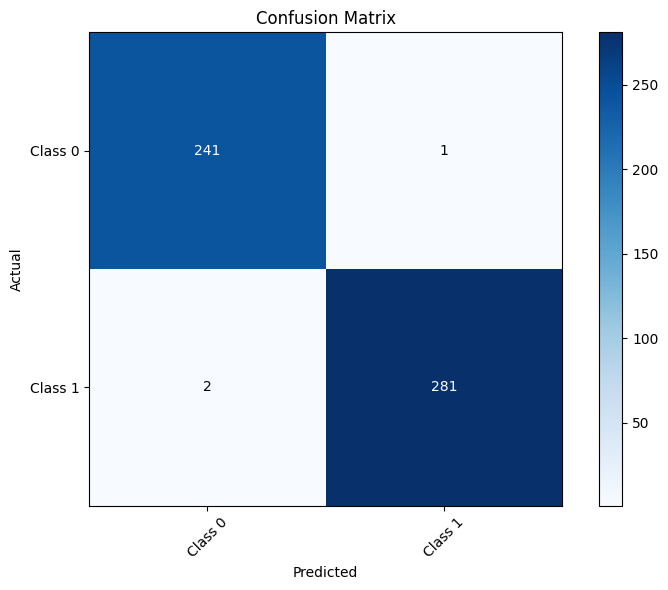

In [20]:
### START CODE HERE ###

device = 'cuda' if torch.cuda.is_available() else 'cpu'
all_digits = []
all_digits_pred = []
all_languages = []
all_languages_pred = []
model = model.to(device)

for images, digits, languages in test_loader:
    images = images.to(device)
    digits = digits.to(device)
    languages = languages.to(device)

    with torch.no_grad():
        out_digit, out_lang = model(images)
        _, digit_pred = torch.max(out_digit, 1)
        _, language_pred = torch.max(out_lang, 1)

    all_digits.extend(digits.cpu().numpy())
    all_digits_pred.extend(digit_pred.cpu().numpy())
    all_languages.extend(languages.cpu().numpy())
    all_languages_pred.extend(language_pred.cpu().numpy())

all_digits = np.array(all_digits)
all_digits_pred = np.array(all_digits_pred)
all_languages = np.array(all_languages)
all_languages_pred = np.array(all_languages_pred)

evaluate_task(all_digits, all_digits_pred, target_names=[f'Class {i}' for i in range(10)])
evaluate_task(all_languages, all_languages_pred, target_names=[f'Class {i}' for i in range(2)])

### END CODE HERE ###

---
# Question
1. If you build two separate models, one for each task with a different classification problem, 
how does the overall model size of two separate models compared to a single model with shared layers and two classifiers 
at the end?

2. In what scenarios might a single model with two classifiers outperform two separate models in terms of generalization? Is there a risk of one task negatively affecting the other?

3. How can weighted loss functions be applied in a single model with two classifiers to balance the performance of both tasks?

### 1. If you build two separate models, one for each task with a different classification problem, how does the overall model size of two separate models compared to a single model with shared layers and two classifiers at the end?
- **Two separate models**: จะมีขนาดรวมคือขนาดของ Layers เเละ Parameters ของเเต่ละ model รวมกัน

- **Single model with shared layers and two classifiers**: จะมีขนาดรวมเล็กกว่าเเบบ Two separate model เนื่องจากมีการ share layers ร่วมกันเเละเเยกกันเเค่ส่วน classifier เท่านั้นทำให้ขนาดเล็กกว่า

### 2. In what scenarios might a single model with two classifiers outperform two separate models in terms of generalization? Is there a risk of one task negatively affecting the other?
- **Outperform two separate models**: อาจเกิดขึ้นได้เมื่อ task ทั้งสองมีความคล้ายกันทำให้ shared layers มีการเรียนรู้ที่ดีกับ task ทั้งสอง

- **Negatively affecting the other**: อาจเกิดขึ้นเมื่อ task ทั้งสองมีความต่างกันมากเกินไปทำให้ shared layers ไม่สามารถปรับให้เหมาะสมกับทั้งสอง task ได้

### 3. How can weighted loss functions be applied in a single model with two classifiers to balance the performance of both tasks?
- **Weighted loss functions**: single model with two classifiers จะทำการรวม loss ของเเต่ละ task ที่คูณกับ weight ของตัวเองโดยอาจให้ weight กับ task ที่ loss มากหรือเรียนรู้ได้ช้ามากกว่า